In [11]:
# native libraries
from collections import defaultdict
import os
from time import time
import pickle

# 3rd party libraries
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# User created library 
from  cross_val_tool_with_PARALLEL import cross_validation_with_PARALLEL as cross_validation

%matplotlib inline
from ETL_functions import *

In [17]:
regression_data = "raw_data/googleplaystore.csv"
classification_data = "raw_data/churn.csv"

load_process_save_regression(regression_data)
load_process_save_classification(classification_data)

# Goal
Since I have another directory dedicted to the workings of ths tool, here I will simply focus on the comparing the speed up we get from parallelizing the model building functionality of the cross validation tool. 

----

### Custom Built Learning Curve Tool¶

We are going to be using a learning curve tool that is an improvement on the [**Sklearn implementation**.](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html)

This custom tool is an improvment in the following way.

While cross validating our model, it scores the model on 4 metrics (Accuracy, Precision, Recall, and F1 Score for classification & RMSE, MSE, MAE, and R2 for regression). The Sklearn version scores the model on only a single metric. Which means that we'd have to cross validate our model several times on the same data in order to get scores for all 4 metircs -- which is not a very intelligent way of doing things. Also, this tool has a method that plots the learning curves of all 4 metrics for you. Lastly, this tool allows you to parallelize the modeling building process. Pretty useful!

```python
cv = cross_validation(model,                 # classification model
                      X_train,               # Training Predictors
                      Y_train ,              # Training Target
                      n_splits=10,           # Number of KFold splits
                      init_chunk_size = 100, # initial size of training set
                      chunk_spacings = 25,   # number of samples to increase the training set by for each iteration 
                      average = "binary")    # score metrics need the type of classification average specified (binary or multi-class)

```


**How this tool works**

1. Take the number of samples from the training set as specified in init_chunk_size
2. Perform n_splits on the data
3. Score the model on the test folds and average the scores across all the folds
4. Score the model on the training set and average the scores across all the folds
5. Store the metric's average scores in a list for the training and test folds
6. Increase the training set size by the number specified in chunk_spacings
7. Repead steps 2 through 5 until all training points are included in the training set
8. Call the plot_learning_curve method to visualize the results

-----

### Test Regression 

In [2]:
regression_data = "./ETL_data/googleAppStore_data.pkl"
X_data, Y_data = pickle.load(open(regression_data, "rb"))

### Building Linear Regression in Series

Time elapsed: 0.7470588684082031


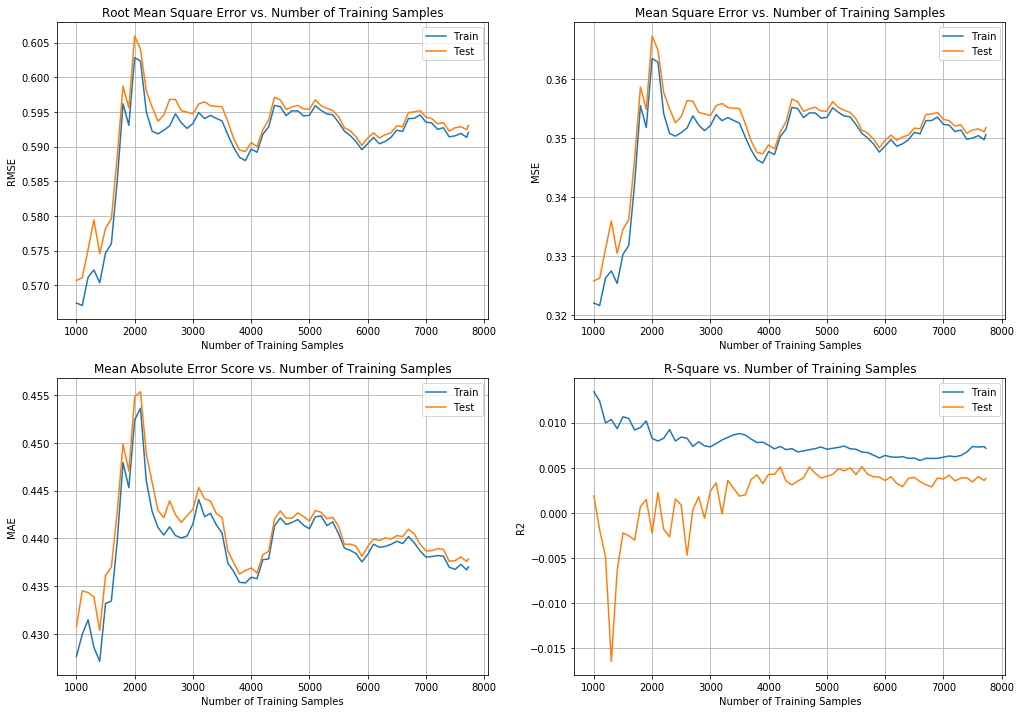

In [12]:
start = time()
lr = LinearRegression()
cv=\
cross_validation(lr, 
                 X_data, 
                 Y_data,
                 n_splits=5, 
                 init_chunk_size=1000, 
                 chunk_spacings=100, 
                 learning_type='regression')

cv.train_for_learning_curve()
cv.plot_learning_curve()
end = time()
print("Time elapsed: {}".format(end-start))

We see that running Linear Regression in series is already a task that requires less than a second to complete. It is unlikely that paralleling this task will results in hugh perforamnce gains. 

### Building Linear Regression in Parallel

Time elapsed: 0.6690387725830078


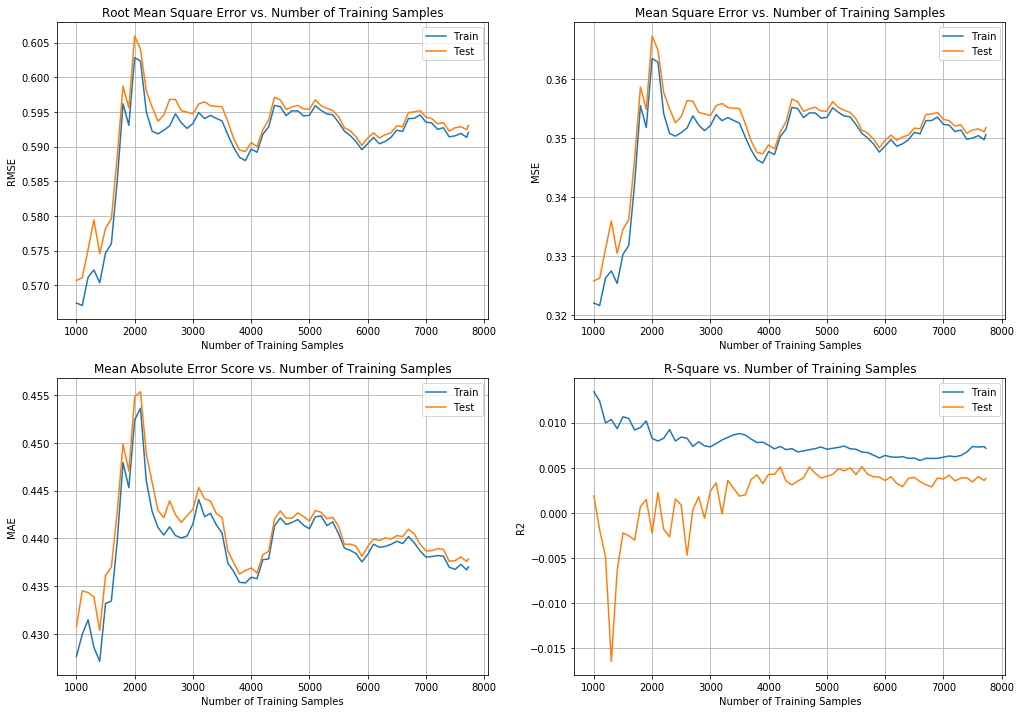

In [10]:
start = time()
lr = LinearRegression()
n_processes=7
cv=\
cross_validation(lr, 
                 X_data, 
                 Y_data,
                 n_splits=5, 
                 init_chunk_size=1000, 
                 chunk_spacings=100, 
                 learning_type='regression')

cv.train_for_learning_curve_PARALLEL(n_processes)
cv.plot_learning_curve()
end = time()
print("Time elapsed: {}".format(end-start))

Ineed, there is a small difference. 

### Building Gradient Boosted Regressor in Series

Now let's build a Gradient Boosted Regressor and increase the number of K-fold splits from 5 to 10. We'll build and score this model both in series and in parallel. 

/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least popula

Time elapsed: 71.1517128944397


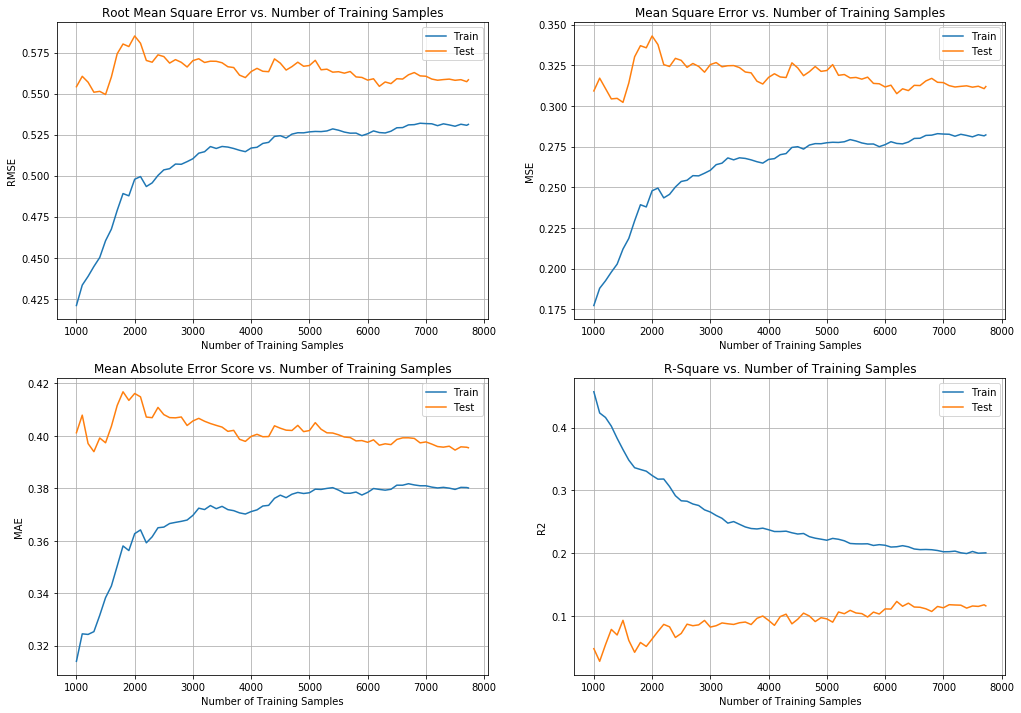

In [25]:
start = time()
gbt = GradientBoostingRegressor()
cv=\
cross_validation(gbt, 
                 X_data, 
                 Y_data,
                 n_splits=10, 
                 init_chunk_size=1000, 
                 chunk_spacings=100, 
                 learning_type='regression')

cv.train_for_learning_curve()
cv.plot_learning_curve()
end = time()
print("Time elapsed: {}".format(end-start))

### Building Gradient Boosted Regressor in Parallel

Here we see that there is a big perforamnce boost. We are able to cut down the run time from 71 seconds to 15 seconds -- that's 20% of the original runtime!

/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least popula

Time elapsed: 15.700878143310547


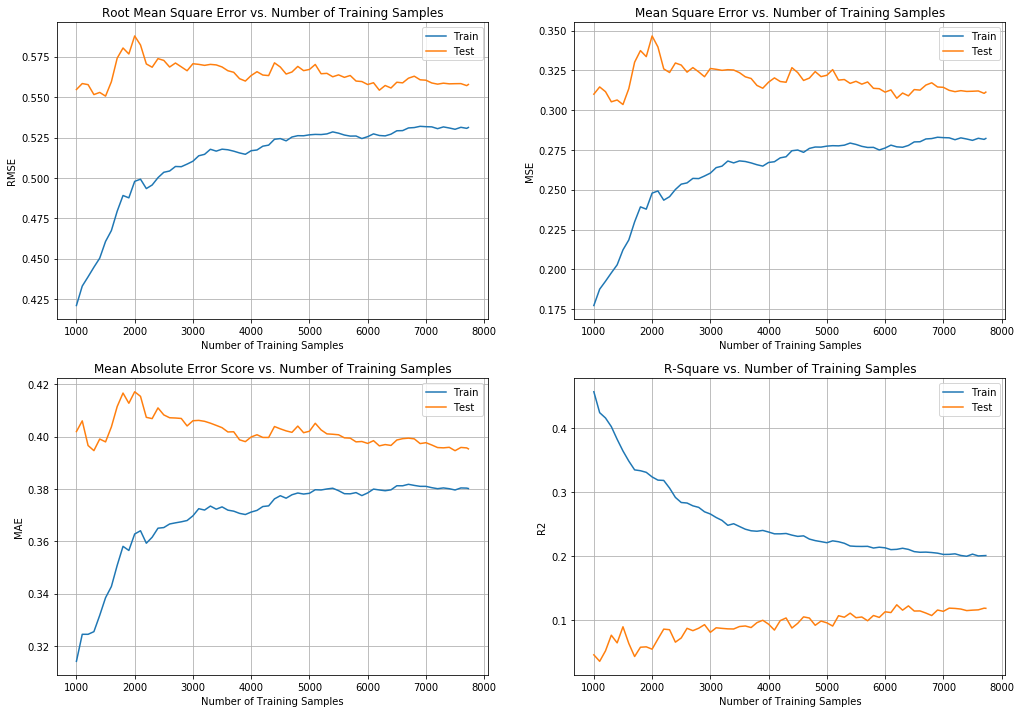

In [32]:
start = time()
gbt = GradientBoostingRegressor()
n_processes=8
cv=\
cross_validation(gbt, 
                 X_data, 
                 Y_data,
                 n_splits=10, 
                 init_chunk_size=1000, 
                 chunk_spacings=100, 
                 learning_type='regression')

cv.train_for_learning_curve_PARALLEL(n_processes)
cv.plot_learning_curve()
end = time()
print("Time elapsed: {}".format(end-start))

Let's perform a more rigorous test on runtimes.

In [36]:
runtime_dict = defaultdict(list)
# iterate through a range of parallel processes
for n_cpus in range(2,11):
    # collect 3 runs for each number of processes so we can take an average 
    for _ in range(3):
    
        start = time()
        gbt = GradientBoostingRegressor()
        cv=\
        cross_validation(gbt, 
                         X_data, 
                         Y_data,
                         n_splits=10, 
                         init_chunk_size=1000, 
                         chunk_spacings=100, 
                         learning_type='regression')

        cv.train_for_learning_curve_PARALLEL(n_cpus)
        end = time()
        runtime_dict[n_cpus].append(end - start)
    print ("{} runs complete".format(n_cpus))

/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/databeast03/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least popula

2 runs complete
3 runs complete
4 runs complete
5 runs complete
6 runs complete
7 runs complete
8 runs complete
9 runs complete
10 runs complete


In [49]:
runtime_means = { key:np.mean(times) for key, times in runtime_dict.items()}
runtime_means

{2: 36.52668491999308,
 3: 24.95806662241618,
 4: 20.982964356740315,
 5: 20.027409712473553,
 6: 19.231025060017902,
 7: 18.567981004714966,
 8: 18.333678881327312,
 9: 18.279245217641193,
 10: 18.44182260831197}

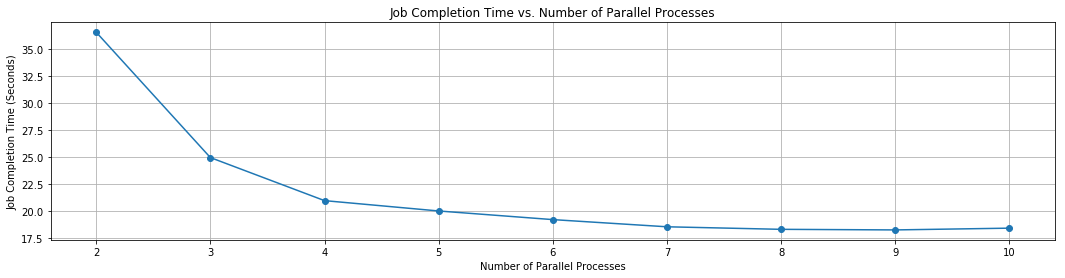

In [48]:
plt.figure(figsize=(18,4))
plt.grid()
plt.title("Job Completion Time vs. Number of Parallel Processes")
plt.ylabel("Job Completion Time (Seconds)")
plt.xlabel("Number of Parallel Processes")
plt.plot(runtime_means.keys(), runtime_means.values(), 'o-');

## Results
 
This test was ran on my local machine which has 8 available cores. This explains why there isn't much of a performance boost when the number of processes exceeds 8. 
More importantly, we do see that there is a significant perforamnce gain between building the model in series and in parallel. 

-----
### Test Classification

Let's go ahead and perform the same tests on the classification data set.

In [2]:
regression_data = "./ETL_data/churn.pkl"
X_churn, Y_churn = pickle.load(open(regression_data, "rb"))

Time Elapsed: 1.6286201477050781


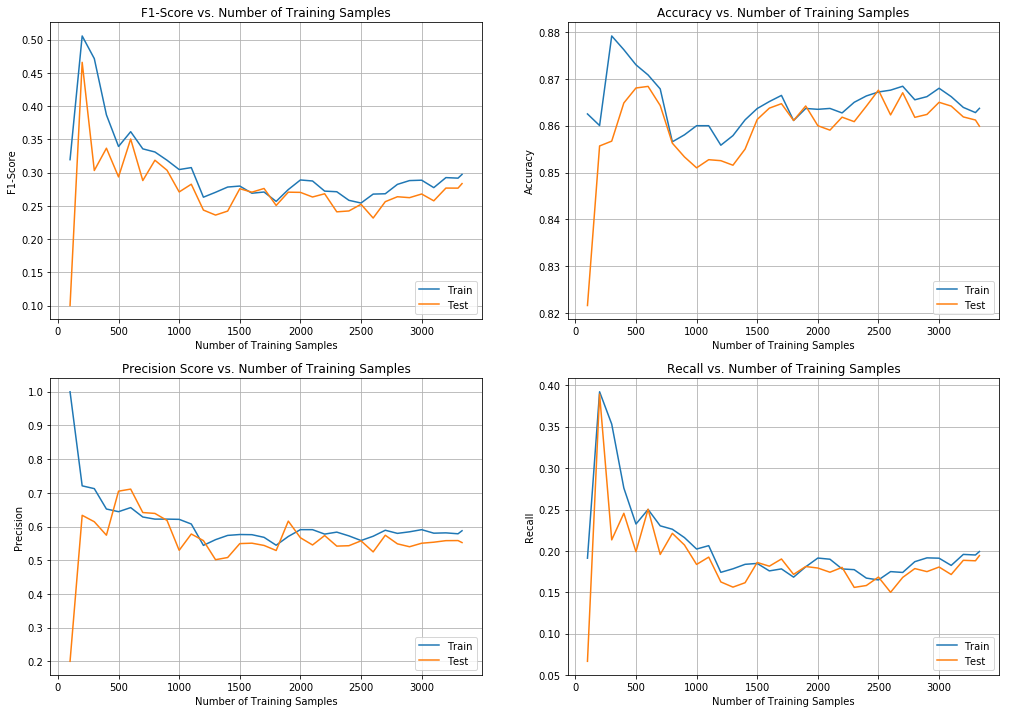

In [4]:
start = time()
lrc = LogisticRegression()
cv=\
cross_validation(lrc, 
                 X_churn, 
                 Y_churn,
                 n_splits=5, 
                 init_chunk_size=100, 
                 chunk_spacings=100, 
                 learning_type='Classification')

cv.train_for_learning_curve()
cv.plot_learning_curve()
end = time()
print ("Time Elapsed: {}".format(end-start))

Time Elapsed: 102.83508682250977


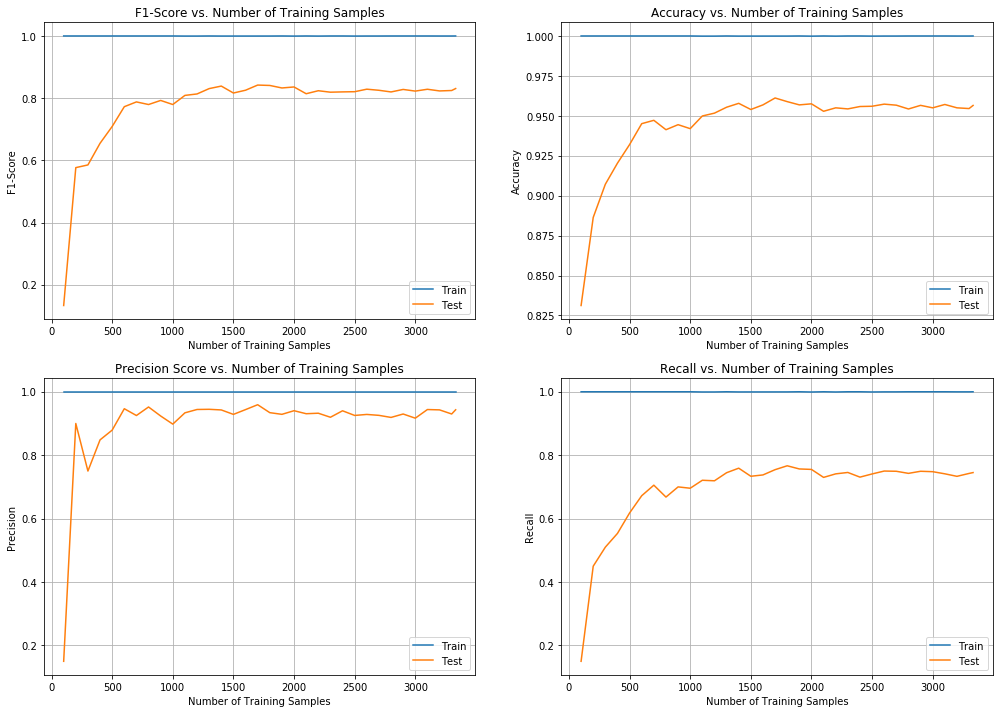

In [5]:
start = time()
rfc = RandomForestClassifier(n_estimators=100)
cv=\
cross_validation(rfc, 
                 X_churn, 
                 Y_churn,
                 n_splits=10, 
                 init_chunk_size=100, 
                 chunk_spacings=100, 
                 learning_type='Classification')

cv.train_for_learning_curve()
cv.plot_learning_curve()
end = time()
print ("Time Elapsed: {}".format(end-start))

Time Elapsed: 23.209699869155884


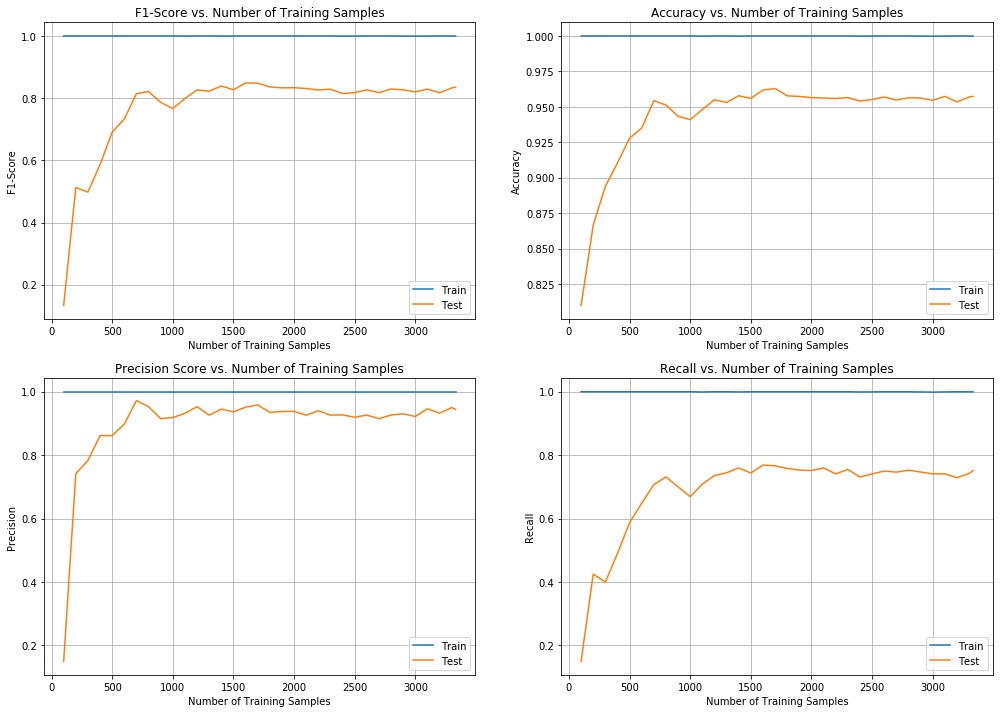

In [5]:
start = time()
rfc = RandomForestClassifier(n_estimators=100)
n_processes=8
cv=\
cross_validation(rfc, 
                 X_churn, 
                 Y_churn,
                 n_splits=10, 
                 init_chunk_size=100, 
                 chunk_spacings=100, 
                 learning_type='Classification')

cv.train_for_learning_curve_PARALLEL(n_processes)
cv.plot_learning_curve()
end = time()
print ("Time Elapsed: {}".format(end-start))

In [6]:
runtime_dict_classification = defaultdict(list)
rfc = RandomForestClassifier(n_estimators=100)
# iterate through a range of parallel processes
for n_cpus in range(2,11):
    # collect 3 runs for each number of processes so we can take an average 
    for _ in range(3):
    
        start = time()
        cv=\
        cross_validation(rfc, 
                         X_churn, 
                         Y_churn,
                         n_splits=10, 
                         init_chunk_size=100, 
                         chunk_spacings=100, 
                         learning_type='Classification')

        cv.train_for_learning_curve_PARALLEL(n_cpus)
        end = time()
        runtime_dict_classification[n_cpus].append(end - start)
    print ("{} runs complete".format(n_cpus))

2 runs complete
3 runs complete
4 runs complete
5 runs complete
6 runs complete
7 runs complete
8 runs complete
9 runs complete
10 runs complete


In [7]:
runtime_means_clf = { key:np.mean(times) for key, times in runtime_dict_classification.items()}
runtime_means_clf

{2: 54.51848602294922,
 3: 36.025759061177574,
 4: 29.755976994832356,
 5: 27.75798161824544,
 6: 26.29706033070882,
 7: 27.494418621063232,
 8: 23.935274998346966,
 9: 23.786948283513386,
 10: 23.418711185455322}

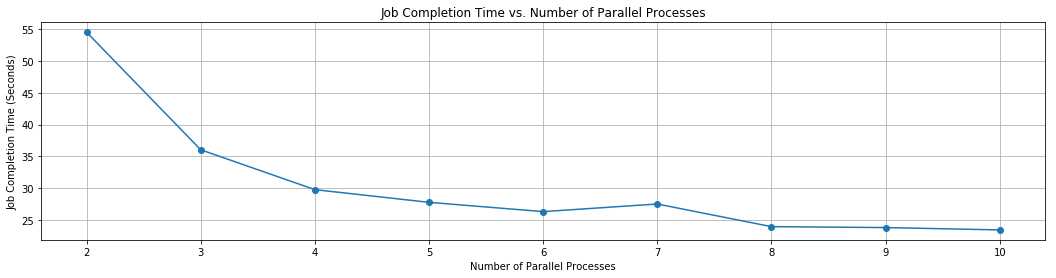

In [9]:
plt.figure(figsize=(18,4))
plt.grid()
plt.title("Job Completion Time vs. Number of Parallel Processes")
plt.ylabel("Job Completion Time (Seconds)")
plt.xlabel("Number of Parallel Processes")
plt.plot(runtime_means_clf.keys(), runtime_means_clf.values(), 'o-');

### Results

Once again we are able to cut down the run time significantly from 103 seconds to just 23 seconds -- that's 22% of the original runtime!